In [5]:
import itertools
import numpy as np

# ==== パラメータ設定 ====
num_orbitals = 6
num_particles = 3
delta = 1.0   # 1体項の等間隔エネルギー
v = 0.3       # 2体相互作用（同じ縮退ペア間のみ）
w3 = 0.2      # 3体相互作用（全てのトリプレット間）

# ==== 基底生成 ====
def generate_basis(num_orbitals, num_particles):
    basis = []
    for bits in itertools.combinations(range(num_orbitals), num_particles):
        occ = np.zeros(num_orbitals, dtype=int)
        occ[list(bits)] = 1
        basis.append(tuple(occ))
    return basis

basis = generate_basis(num_orbitals, num_particles)
dim = len(basis)

# ==== 生成消滅演算の定義（フェルミ符号を含む） ====
def apply_annihilate(state, i):
    state = list(state)
    if state[i] == 0:
        return None, 0
    sign = (-1)**sum(state[:i])
    state[i] = 0
    return tuple(state), sign

def apply_create(state, i):
    state = list(state)
    if state[i] == 1:
        return None, 0
    sign = (-1)**sum(state[:i])
    state[i] = 1
    return tuple(state), sign

def apply_cdag_c(state, i, j):
    """c_i† c_j"""
    s1, sign1 = apply_annihilate(state, j)
    if s1 is None:
        return None, 0
    s2, sign2 = apply_create(s1, i)
    if s2 is None:
        return None, 0
    return s2, sign1 * sign2

# ==== 1体ハミルトニアン ====
H1 = np.zeros((dim, dim))
for p, s in enumerate(basis):
    for i, occ in enumerate(s):
        if occ == 1:
            energy = delta * (i // 2)  # 各2縮退レベルごとに等間隔
            H1[p, p] += energy

# ==== 2体ハミルトニアン ====
pairs = [(0,1), (2,3), (4,5)]
H2 = np.zeros((dim, dim))

for (a,b) in pairs:
    for i, s in enumerate(basis):
        # 密度項（両方占有）
        if s[a] == 1 and s[b] == 1:
            H2[i, i] += v

        # 交換項 a→b
        if s[a] == 1 and s[b] == 0:
            s2, sign = apply_cdag_c(s, b, a)
            if s2 in basis:
                j = basis.index(s2)
                H2[i, j] += v * sign

        # 交換項 b→a（逆方向も入れる）
        if s[b] == 1 and s[a] == 0:
            s2, sign = apply_cdag_c(s, a, b)
            if s2 in basis:
                j = basis.index(s2)
                H2[i, j] += v * sign

# ==== 3体ハミルトニアン ====
triplets = [(0,1,2), (1,2,3), (2,3,4), (3,4,5)]
H3 = np.zeros((dim, dim))

# 全ての triplet → triplet 結合を入れる
for T1 in triplets:
    for T2 in triplets:
        for i, s in enumerate(basis):
            # T2をすべて占有している場合のみ作用
            if all(s[k] == 1 for k in T2):
                s_new = list(s)
                sign = 1
                # まず T2 をアニヒレート
                for k in reversed(T2):
                    s_new, sgn = apply_annihilate(s_new, k)
                    if s_new is None:
                        break
                    sign *= sgn
                if s_new is None:
                    continue
                # 次に T1 を作る
                for k in T1:
                    s_new, sgn = apply_create(s_new, k)
                    if s_new is None:
                        break
                    sign *= sgn
                if s_new is None:
                    continue
                s_new = tuple(s_new)
                if s_new in basis:
                    j = basis.index(s_new)
                    H3[i, j] += w3 * sign

# ==== 総ハミルトニアン ====
H = H1 + H2 + H3
H = H # Hermitize（実対称に）

# ==== 結果表示 ====
np.set_printoptions(precision=2, suppress=True)
print("Hamiltonian matrix (dim={}):".format(dim))
print(H)

# ==== 固有値 ====
eigvals, _ = np.linalg.eigh(H)
print("\nEigenvalues:")
print(np.round(eigvals, 4))

Hamiltonian matrix (dim=20):
[[1.5 0.3 0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.2 0.
  0.  0.2]
 [0.3 1.3 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  2.3 0.3 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.3 2.3 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  2.3 0.  0.  0.  0.  0.  0.3 0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  3.  0.3 0.3 0.  0.  0.  0.3 0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.3 3.  0.  0.3 0.  0.  0.  0.3 0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.3 0.  3.  0.3 0.  0.  0.  0.  0.3 0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.3 0.3 3.  0.  0.  0.  0.  0.  0.3 0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  4.3 0.  0.  0.  0.  0.  0.3 0.  0.
  0.  0. ]
 [0.2 0.  0.  0.  0.3 0.  0.  0.  0.  0.  2.5 0.  0.  0.  0.  0.  0.2 0.
  0.  0.2]
 [0.  0.  0.  0.  0.  0.3 0.  0.  0.  0.  0.  3

In [ ]:
# === 前提：上で作った basis, H が既に定義済み ===
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library import QFT, StatePreparation
from qiskit_aer import Aer

# ----- 20 次元（C(6,3)=20）を 5 量子ビット（32 次元）に埋め込む -----
n_sys = 5                    # 2^5 = 32 >= 20
dim = len(basis)             # = 20

# H は対称行列になっている想定（np.linalg.eigh を使う）
evals, evecs = np.linalg.eigh(H)   # H = V diag(evals) V^T

def U_embed(time):
    """U = exp(-i H time) を 32x32 に埋め込んだ UnitaryGate を返す"""
    phases = np.exp(-1j * evals * time)
    U20 = (evecs @ np.diag(phases) @ evecs.T)   # 対称なので転置でOK
    U32 = np.eye(2**n_sys, dtype=complex)
    U32[:dim, :dim] = U20
    return UnitaryGate(U32, label=f"e^(-iHt), t={time:g}")

# ----- 初期状態（2通り） -----
# (A) 素朴に |0...0> を使う（基底状態との重なりが小さいと当たらないことあり）
psi0 = None

# (B) 基底固有ベクトルで初期化（テスト用・確実）
#     本番では VQE 等で近似基底を用意して渡すのがおすすめ
use_ground_state_prep = True
prep = None
if use_ground_state_prep:
    gvec20 = evecs[:, 0]                       # 基底の固有ベクトル
    gvec32 = np.zeros(2**n_sys, dtype=complex)
    gvec32[:dim] = gvec20
    prep = StatePreparation(gvec32)

# ----- QPE 本体 -----
def qpe_energy(H_evals, num_eval_qubits=10, shots=4096, t=None, psi_prep=None):
    # スペクトル幅の上界を使って折り返しを避ける t を自動選択
    # ざっくり max(|E|) * t < π を目安に
    Emax = float(np.max(np.abs(H_evals)))
    if t is None:
        t = np.pi / (2.0 * max(Emax, 1e-12))

    qr_anc = QuantumRegister(num_eval_qubits, "anc")
    qr_sys = QuantumRegister(n_sys, "sys")
    cr = ClassicalRegister(num_eval_qubits, "c")
    qc = QuantumCircuit(qr_anc, qr_sys, cr)

    # 初期化
    if psi_prep is not None:
        qc.append(psi_prep, qr_sys)

    # Hadamard on ancillas
    qc.h(qr_anc)

    # controlled-U^{2^k}（U = exp(-i H t) を直接行列から作る）
    for k in range(num_eval_qubits):
        Uk = U_embed(t * (2**k)).control(1)
        qc.append(Uk, [qr_anc[k], *qr_sys])

    # 逆QFT
    iqft = QFT(num_eval_qubits, do_swaps=True).inverse()
    qc.append(iqft, qr_anc)

    # 測定
    qc.measure(qr_anc, cr)

    # 実行
    backend = Aer.get_backend("aer_simulator")
    tqc = transpile(qc, backend)
    res = backend.run(tqc, shots=shots).result()
    counts = res.get_counts()

    # 最頻ビット列から位相→エネルギーへ
    bitstring = max(counts, key=counts.get)
    k = int(bitstring, 2)  # 逆順が必要なら bitstring[::-1]
    phi = k / (2**num_eval_qubits)
    theta = 2*np.pi*phi
    if theta > np.pi:   # (-π, π] に折り返し
        theta -= 2*np.pi
    E_est = theta / t

    return {"energy": E_est, "phase": phi, "bitstring": bitstring, "t": t,
            "counts": counts, "circuit": qc}

# 実行（基底ベクトルで初期化する安全版）
out = qpe_energy(evals, num_eval_qubits=10, shots=8192, t=None, psi_prep=prep)
print("=== QPE (matrix-embedding) ===")
print("bitstring :", out["bitstring"])
print("phase     :", out["phase"])
print("t         :", out["t"])
print("E (est.)  :", out["energy"])
print("E (exact) :", evals[0])


/tmp/ipykernel_526082/1979591332.py:63: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft = QFT(num_eval_qubits, do_swaps=True).inverse()


=== QPE (matrix-embedding) ===
bitstring : 1111010001
phase     : 0.9541015625
t         : 0.2726750678878558
E (est.)  : -1.0576265382690118
E (exact) : 1.0680059267755584


In [7]:
# =========================
# 2) QPE（行列埋め込み: e^{-iHt} を直接ユニタリ化）
# =========================
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import UnitaryGate, StatePreparation   # ← QFTGate は使わない
from qiskit_aer import Aer
import numpy as np

# 20 次元を 5量子ビット(32次元)へ埋め込み
n_sys = int(np.ceil(np.log2(dim)))  # = 5
dim2 = 2**n_sys

def U_embed(time: float) -> UnitaryGate:
    """U = exp(-i H time) を dim2 x dim2 に埋め込んで返す"""
    phases = np.exp(-1j * evals * time)
    U20 = (evecs @ np.diag(phases) @ evecs.conj().T)
    U32 = np.eye(dim2, dtype=complex)
    U32[:dim, :dim] = U20
    return UnitaryGate(U32, label=f"e^(-iHt), t={time:g}")

def apply_iqft(qc: QuantumCircuit, qubits):
    """逆QFT（スワップ込み）を自前実装（Qiskit 2.x 互換）"""
    n = len(qubits)
    # スワップでビット順を反転（QFTのdo_swaps=Trueと同じ効果）
    for j in range(n // 2):
        qc.swap(qubits[j], qubits[n - 1 - j])
    # IQFT 本体
    for j in range(n - 1, -1, -1):
        for m in range(j - 1, -1, -1):
            qc.cp(-np.pi / (2 ** (j - m)), qubits[m], qubits[j])
        qc.h(qubits[j])

def qpe_energy(H_evals, num_eval_qubits=10, shots=8192, t=None, psi_prep=None, reverse_bits=False):
    # ざっくり max|E| * t < π を目安に自動設定
    Emax = float(np.max(np.abs(H_evals)))
    if t is None:
        t = np.pi / (2.0 * max(Emax, 1e-12))

    qr_anc = QuantumRegister(num_eval_qubits, "anc")
    qr_sys = QuantumRegister(n_sys, "sys")
    cr = ClassicalRegister(num_eval_qubits, "c")
    qc = QuantumCircuit(qr_anc, qr_sys, cr)

    # 初期状態（基底推定のため基底近傍を推奨）
    if psi_prep is not None:
        qc.append(psi_prep, qr_sys)

    # Hadamard で均等重ね合わせ
    qc.h(qr_anc)

    # controlled-U^{2^k}
    for k in range(num_eval_qubits):
        Uk = U_embed(t * (2**k)).control(1)
        qc.append(Uk, [qr_anc[k], *qr_sys])

    # 逆QFT（自前実装）
    apply_iqft(qc, qr_anc)

    # 測定
    qc.measure(qr_anc, cr)

    backend = Aer.get_backend("aer_simulator")
    tqc = transpile(qc, backend)
    result = backend.run(tqc, shots=shots).result()
    counts = result.get_counts()

    # 最頻ビット列 → 位相 → エネルギー
    bitstring = max(counts, key=counts.get)
    bitstring_use = bitstring[::-1] if reverse_bits else bitstring
    k = int(bitstring_use, 2)
    phi = k / (2**num_eval_qubits)
    theta = 2.0 * np.pi * phi
    if theta > np.pi:
        theta -= 2.0 * np.pi
    energy_est = -theta / t  # U = e^{-iHt}

    return {
        "energy": energy_est,
        "phase": phi,
        "bitstring": bitstring,
        "t": t,
        "counts": counts,
        "circuit": qc,
    }

# --- 基底状態で初期化（検証用に厳密基底を使用）---
gvec20 = evecs[:, 0]
gvec32 = np.zeros(dim2, dtype=complex)
gvec32[:dim] = gvec20
prep = StatePreparation(gvec32)

out = qpe_energy(evals, num_eval_qubits=10, shots=8192, t=None, psi_prep=prep, reverse_bits=False)

print("\n=== QPE (matrix-embedding) ===")
print("bitstring :", out["bitstring"])
print("phase     :", out["phase"])
print("t         :", out["t"])
print("E (est.)  :", out["energy"])
print("E (exact) :", evals[0])


=== QPE (matrix-embedding) ===
bitstring : 1100101110
phase     : 0.794921875
t         : 0.2726750678878558
E (est.)  : 4.725565383755155
E (exact) : 1.0680059267755584


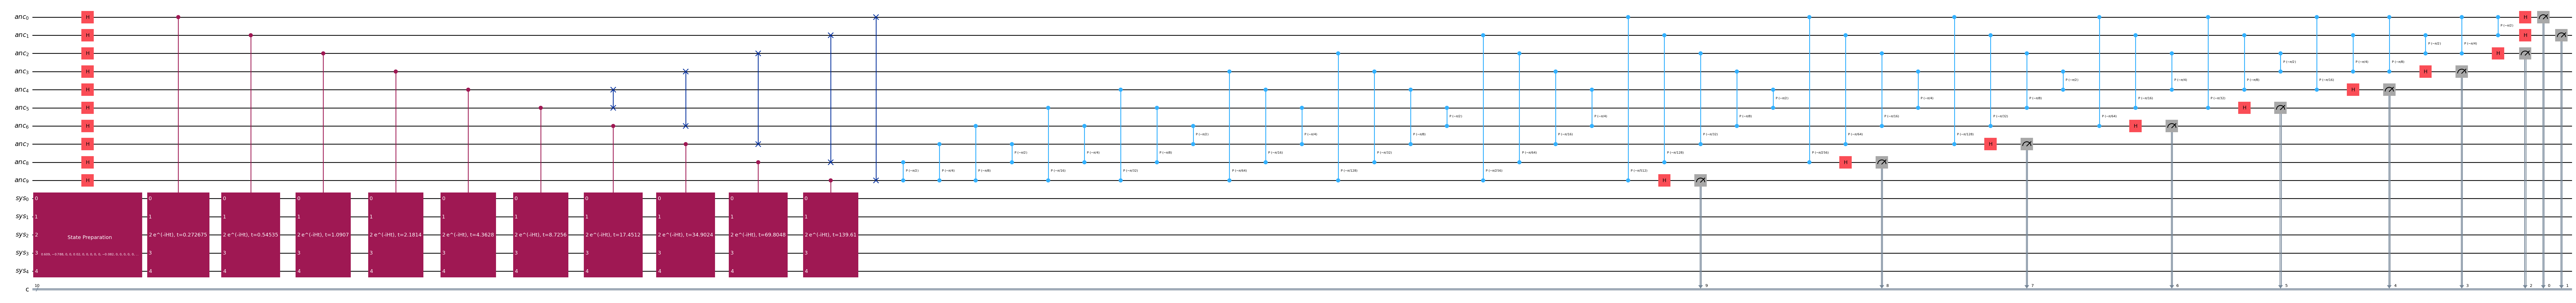

In [ ]:
out["circuit"].draw(
    output="mpl",
    fold=-1,  # 折り返しを無効化（横に全展開）
    # vertical_compression="high",  # 縦方向の間隔を詰める
)